In [2]:
import tensorflow as tf
import tensorflow_text as text
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import time
import os

In [3]:
import pandas as pd
df=pd.read_csv('spam.csv')
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [5]:
df.Category.value_counts()

,count
Category,
ham,4825
spam,747


In [6]:
df_ham=df[df.Category=='ham']
df_ham.shape

(4825, 2)

In [7]:
df_ham_downsampled=df[df.Category=='ham'].sample(4000)
df_ham_downsampled.shape

(4000, 2)

In [8]:
df_spam=df[df.Category=='spam']
df_spam.shape

(747, 2)

In [9]:
df_spam_upsampled=df[df.Category=='spam'].sample(4000,replace=True)
df_spam_upsampled.shape

(4000, 2)

In [10]:
df_balanced=pd.concat([df_spam_upsampled,df_ham_downsampled],axis=0)
df_balanced.shape

(8000, 2)

In [11]:
df_balanced['Category'].value_counts()

,count
Category,
spam,4000
ham,4000


In [12]:
df_balanced.sample(5)

,Category,Message
2802,ham,Depends on where u going lor.
5566,spam,REMINDER FROM O2: To get 2.50 pounds free call...
2758,ham,Yo we are watching a movie on netflix
2575,spam,Your next amazing xxx PICSFREE1 video will be ...
3766,spam,Someone U know has asked our dating service 2 ...


In [13]:
df_balanced['spam']=df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

,Category,Message,spam
4752,spam,Your weekly Cool-Mob tones are ready to downlo...,1
3456,ham,No need lar. Jus testing e phone card. Dunno n...,0
1927,ham,Dont give a monkeys wot they think and i certa...,0
3856,spam,Free msg: Single? Find a partner in your area!...,1
2440,ham,Rightio. 11.48 it is then. Well arent we all u...,0


In [14]:
X=df_balanced['Message']
y=df_balanced['spam']

In [15]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y)

In [16]:
X_train.head(2)

,Message
3869,"not that I know of, most people up here are st..."
1298,"K so am I, how much for an 8th? Fifty?"


In [17]:
bert_preprocess=hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',trainable=False)
bert_encoder=hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4',trainable=True)

In [18]:
def get_batched_sentence_embeding(sentences, batch_size=256):
    all_embeddings = []
    sentences_np = sentences.to_numpy()

    for i in range(0, len(sentences_np), batch_size):
        batch_sentences = sentences_np[i:i + batch_size]
        batch_sentences_tf = tf.constant(batch_sentences.tolist(), dtype=tf.string)

        preprocessed_text = bert_preprocess(batch_sentences_tf)
        batch_embeddings = bert_encoder(preprocessed_text)['pooled_output']

        all_embeddings.append(batch_embeddings)

    return tf.concat(all_embeddings, axis=0)

In [19]:
def get_sentence_embeding(sentences):
    sentences = tf.constant(sentences, dtype=tf.string)
    preprocessed_text=bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding(['$500 discount. Hurry up',
                       'Dude, are you up for volleyball game tomorrow'])


<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.89717406, -0.517493  , -0.9215329 , ..., -0.8024575 ,
        -0.77315176,  0.93912673],
       [-0.92817926, -0.64317703, -0.96491736, ..., -0.9076436 ,
        -0.7393728 ,  0.920251  ]], dtype=float32)>

In [20]:
X_train_embed = get_batched_sentence_embeding(X_train)
X_test_embed = get_batched_sentence_embeding(X_test)

y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()

def get_bert_classifier():
    input_emb = keras.layers.Input(shape=(768,), name='BERT_embedding')
    l = keras.layers.Dropout(0.1, name="dropout")(input_emb)
    l = keras.layers.Dense(1, activation='sigmoid', name="output")(l)
    model = keras.Model(inputs=[input_emb], outputs=[l])

    METRICS= [
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=METRICS)
    return model

In [22]:
model=get_bert_classifier()

In [23]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ BERT_embedding (InputLayer)     │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           769 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 769 (3.00 KB)

 Trainable params: 769 (3.00 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
y_train_tensor = tf.convert_to_tensor(y_train_np, dtype=tf.int32)
y_test_tensor = tf.convert_to_tensor(y_test_np, dtype=tf.int32)
print("\n--- GPU/CPU Benchmarking (5 Epochs) ---")
SLICE_SIZE = len(X_train_embed)

X_slice = X_train_embed[:SLICE_SIZE]
y_slice = y_train_tensor[:SLICE_SIZE]

def benchmark_train(model, X_data, y_data):
    start_time = time.time()
    model.fit(X_data, y_data, epochs=5, verbose=0)
    end_time = time.time()
    return end_time - start_time

with tf.device('/CPU:0'):
    cpu_model = get_bert_classifier()
    cpu_time = benchmark_train(cpu_model, X_slice, y_slice)
    print(f"CPU Training Time (5 epochs): {cpu_time:.4f}s")

try:
    with tf.device('/GPU:0'):
        gpu_model = get_bert_classifier()
        gpu_time = benchmark_train(gpu_model, X_slice, y_slice)
        print(f"GPU Training Time (5 epochs): {gpu_time:.4f}s")
        print(f"GPU speedup factor: {cpu_time/gpu_time:.2f}x")
except RuntimeError:
    print("GPU not available for explicit benchmarking.")


--- GPU/CPU Benchmarking (5 Epochs) ---
CPU Training Time (5 epochs): 5.5076s
GPU Training Time (5 epochs): 4.6219s
GPU speedup factor: 1.19x


In [26]:
BATCH_SIZE = 64
EPOCHS = 10

train_ds = tf.data.Dataset.from_tensor_slices((X_train_embed, y_train_tensor))
train_ds = train_ds.shuffle(len(X_train_embed)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

final_model = get_bert_classifier()
METRICS = [tf.keras.metrics.BinaryAccuracy(name='accuracy'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
final_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

final_model.fit(train_ds, epochs=EPOCHS)

import numpy as np

loss, acc, prec, recall = final_model.evaluate(X_test_embed, y_test_tensor, verbose=0)
y_predicted = np.round(final_model.predict(X_test_embed)).flatten()

print("\n--- Final Model Performance ---")
print(f"Test Accuracy: {acc:.4f}")
print("Classification Report:")
print(classification_report(y_test_np, y_predicted))

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6607 - loss: 0.6277 - precision: 0.6596 - recall: 0.6459
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8720 - loss: 0.3972 - precision: 0.8683 - recall: 0.8776
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9013 - loss: 0.3192 - precision: 0.8852 - recall: 0.9216
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9105 - loss: 0.2743 - precision: 0.9060 - recall: 0.9136
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9195 - loss: 0.2560 - precision: 0.9154 - recall: 0.9287
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9210 - loss: 0.2377 - precision: 0.9195 - recall: 0.9243
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9349 - loss: 0.2143 - precision: 0.9265 - recall: 0.9491
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9346 - loss: 0.2076 - precision: 0.9355 - recall: 0.9333
Epoch 9/10
94/94 ━━━━━━━━━━━━━━

In [27]:
from sklearn.metrics import confusion_matrix, classification_report
cm= confusion_matrix(y_test,y_predicted)
cm

array([[936,  64],
       [ 34, 966]])

Text(50.722222222222214, 0.5, 'Truth')

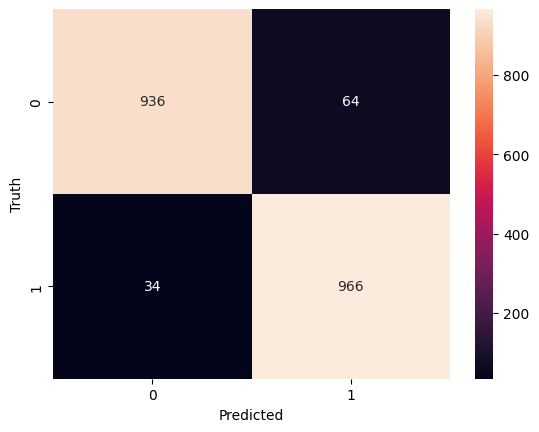

In [28]:
import matplotlib.pyplot as plt
import seaborn as sn

sn.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [34]:
reviews = [
    "Reply to win £100 weekly! Where will the 2006 FIFA World Cup be held? Send STOP to 87239 to end service.",
    "You are awarded a SiPix Digital Camera! Call 09061221061 from a landline. Delivery within 28 days. T&Cs Box177 M221BP. 2-year warranty. 150ppm. £3.99.",
    "Text it to 80488. Your 500 free text messages are valid until 31 December 2005.",
    "yo sam, what is up dude? You are going to come on friday right?",
    "Why don't you wait until at least Wednesday to see if you get yours?"
]


In [36]:
review_embeds = get_sentence_embeding(tf.constant(reviews))

final_model.predict(review_embeds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


array([[0.9105438 ],
       [0.9174152 ],
       [0.9549538 ],
       [0.07425006],
       [0.03698226]], dtype=float32)

In [39]:
model_dir = "./saved_spam_model"
final_model.export(model_dir)

original_size = os.path.getsize(os.path.join(model_dir, 'saved_model.pb'))

converter_base = tf.lite.TFLiteConverter.from_saved_model(model_dir)
tflite_model_base = converter_base.convert()
base_size = len(tflite_model_base)

converter_quant = tf.lite.TFLiteConverter.from_saved_model(model_dir)
converter_quant.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter_quant.convert()
quant_size = len(tflite_quant_model)

print("\n--- Model Quantization Results ---")
print(f"Original SavedModel Size (Approx): {original_size / 1024:.2f} KB")
print(f"Base TFLite Model Size: {base_size / 1024:.2f} KB")
print(f"Quantized TFLite Model Size: {quant_size / 1024:.2f} KB")
print(f"Quantization resulted in a size reduction of: {base_size/quant_size:.2f}x")

Saved artifact at './saved_spam_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 768), dtype=tf.float32, name='BERT_embedding')]
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  140566117987344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140566096921808: TensorSpec(shape=(), dtype=tf.resource, name=None)

--- Model Quantization Results ---
Original SavedModel Size (Approx): 23.65 KB
Base TFLite Model Size: 4.27 KB
Quantized TFLite Model Size: 4.27 KB
Quantization resulted in a size reduction of: 1.00x
